In [121]:
import numpy as np
import urllib3
import random 
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Import text file

In [122]:
# Grab text file from github
http = urllib3.PoolManager()
textfile = http.request('GET', 'https://raw.githubusercontent.com/nghess/makemore/master/names.txt')
words = str(textfile.data, 'utf-8').splitlines()

In [123]:
# Take a peak at text file
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [124]:
# Build character to/from string mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [125]:
# Build the dataset
def build_dataset(words):
  block_size = 3  # context length: how many characters do we use to predict the next one?
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] #  Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [126]:
len(words)

32033

In [127]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [128]:
sum(p.nelement() for p in parameters)

11897

In [129]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [130]:
lri = []
lossi = []
stepi = []

In [131]:
# Forward pass
for i in range(200000):

  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)

  # Forward pass
  emb = C[Xtr[ix]]  # (32, 2, 2) by indexing into the dataset 
  h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
  logits = h @ W2 + b2  # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # Backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  # Update
  lr = .1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Track loss
  #lri.append(lr)
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

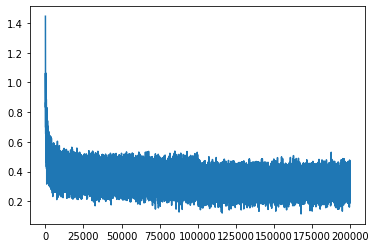

In [133]:
plt.plot(stepi, lossi)

In [134]:
emb = C[Xtr]  # (32, 2, 2) by indexing into the dataset 
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1277, grad_fn=<NllLossBackward0>)

In [135]:
emb = C[Xdev]  # (32, 2, 2) by indexing into the dataset 
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1751, grad_fn=<NllLossBackward0>)

In [142]:
from numpy.ma import outer
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3 

for _ in range(20):

  out=[]
  context = [0] * block_size  # intialize with all...
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

carlah.
amille.
khy.
myli.
taty.
skanden.
jazonen.
amerynchireei.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wanthoniearyn.
kai.
everusabee.
demiia.
